# 1. Preparation

In [2]:
# Install modules
!pip install pytesseract

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract  # OCR: Recognize text

In [4]:
# Load images
image_path = './data/car_license_plate2.png'
image = cv2.imread(image_path, 1)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Get a shape
height, width, channel = image.shape  # Only works in RGB mode
print(f'Size of image: {height}px X {width}px')

Size of image: 850px X 1380px


# 2. Maximize Contrast

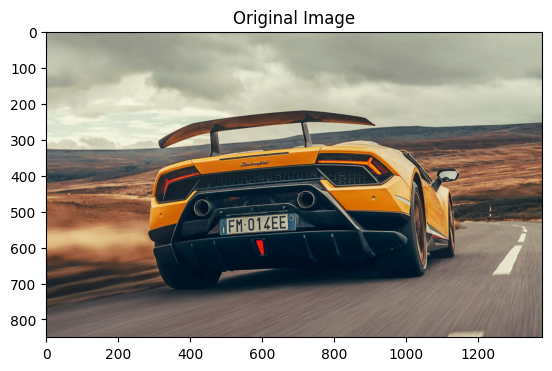

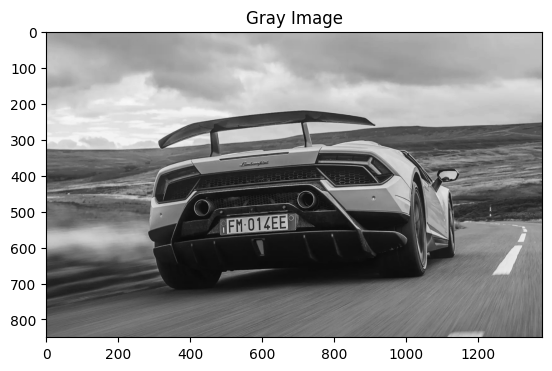

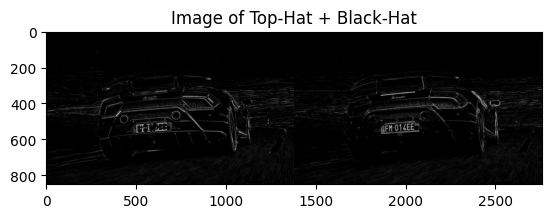

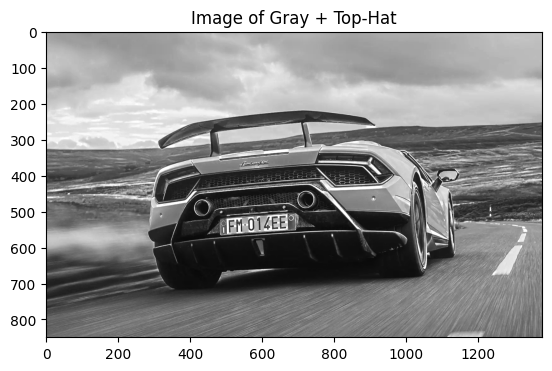

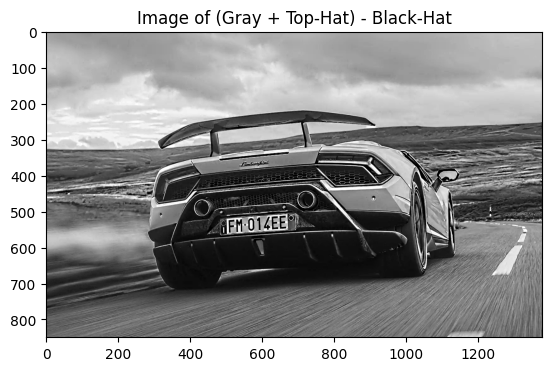

In [21]:
######################################################

# Create a Kernel: Morphological Operation 
#                 -> A small binary matrix or kernel to determine neighborhood relationships like dilation and erosion
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
                                                # cv2.MORPH_RECT: Set the shape as a rectangular shape
                                                # (9, 9): a 9x9 matrix
#print(structuringElement)

######################################################

# A Morphological Top-Hat operation: Highlight the bright structures or details in the grayscale image
image_TopHat = cv2.morphologyEx(image_gray, 
                                cv2.MORPH_TOPHAT, 
                                structuringElement) # determine neighborhood relationships

# A Morphological Black-Hat operation: Highlight dark structures
image_BlackHat = cv2.morphologyEx(image_gray,
                                 cv2.MORPH_BLACKHAT,
                                 structuringElement)  # determine neighborhood relationships

# Make a list of images
image_list = np.hstack([image_TopHat, image_BlackHat])

# Perform element-wise addition between two images
image_GrayPlusTopHat = cv2.add(image_gray, image_TopHat) # gray scaled image + Top Hat image

# Perform a subtraction operation
image_GrayPlusBlackHat = cv2.subtract(image_GrayPlusTopHat, image_BlackHat) # (Gray + Top Hat ) + Black Hat



######################################################

# Visualization
plt.imshow(image_rgb)
plt.title('Original Image')
plt.show()

plt.imshow(image_gray, 'gray')
plt.title('Gray Image')
plt.show()

plt.imshow(image_list, 'gray')
plt.title('Image of Top-Hat + Black-Hat')
plt.show()

plt.imshow(image_GrayPlusTopHat, 'gray')
plt.title('Image of Gray + Top-Hat')
plt.show()

plt.imshow(image_GrayPlusBlackHat, 'gray')
plt.title('Image of (Gray + Top-Hat) - Black-Hat')
plt.show()

# 3. Gaussian Adaptive Thresholding

- Gaussian Adaptive Thresholding
  - Convert a grayscale image into a binary image based on local variations
    - 
  - Adjust threshold value for each pixel based on its local neighborhood
     - Allows adaptive thresholding to handle variations in lighting conditions
     - Improve segmentation accuracy in images

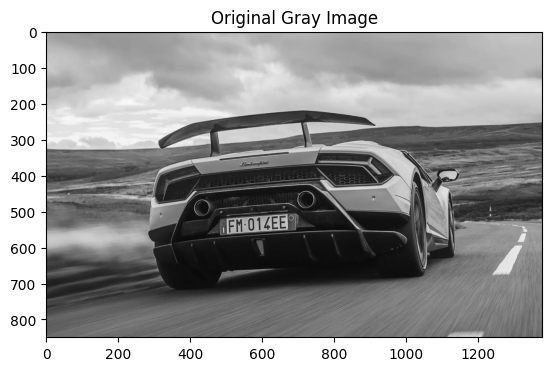

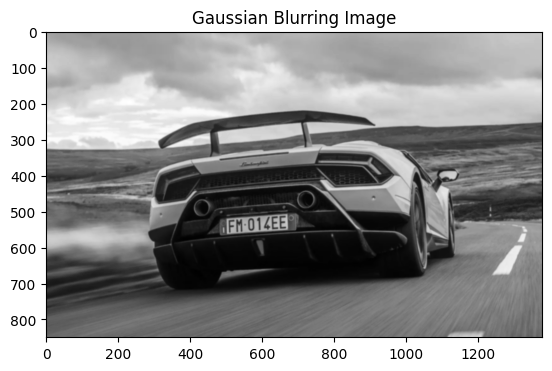

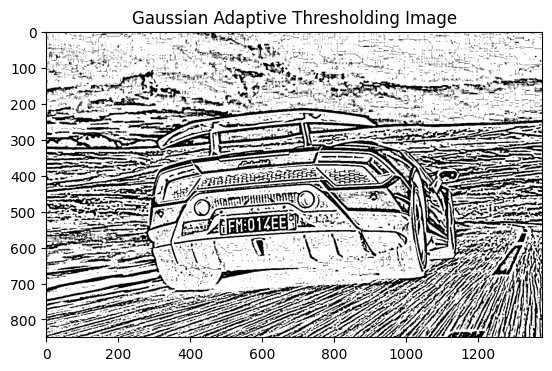

In [6]:
# Blur images: GaussianBlur()
image_blurred = cv2.GaussianBlur(image_gray,
                                ksize=(7, 7),  # Size of kernel -> 7x7 pixels
                                sigmaX=0)     # Standard deviation of Gaussian Kernel in the X direction
                                              # 'sigmaX=0': the std will be calculated automatically based on ksize

######################################################

# Apply Adaptive Thresholding
image_thresh = cv2.adaptiveThreshold(
    image_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # 'cv2.ADAPTIVE_THRESH_GAUSSIAN_C': Threshold value for each pixel is calculated as the wieghted sum of negibhborhood values
    thresholdType=cv2.THRESH_BINARY_INV,            # 'cv2.THRESH_BINARY_INV': pixels > threshold -> Set to '0(black)' 
                                                    #                          pixels < threshold -> Set to 'maxValue=255'
    blockSize=15,  # The size of neighborhood to calcualte threshold value for each pixel -> 15x15 pixels
    C=0   # A constant value
)

    
######################################################

# Visualization
plt.imshow(image_gray, 'gray')
plt.title('Original Gray Image')
plt.show()

plt.imshow(image_blurred, 'gray')
plt.title('Gaussian Blurring Image')
plt.show()

plt.imshow(image_thresh, 'gray')
plt.title('Gaussian Adaptive Thresholding Image')
plt.show()

# 4. Find Contours

<function matplotlib.pyplot.show(close=None, block=None)>

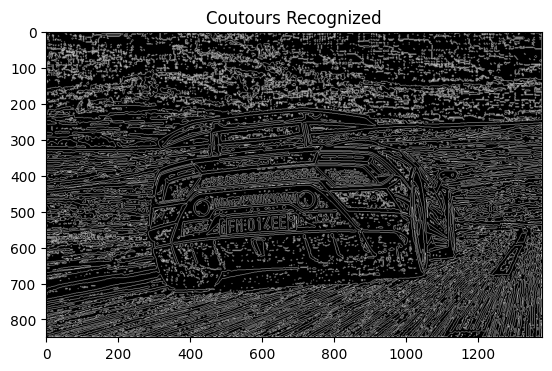

In [7]:
# Find Contours
contours, hierarchy = cv2.findContours(
    image_thresh,
    mode = cv2.RETR_LIST,   # 'mode': Contour retrieval mode
                            # 'cv2.RETR_LIST': All contours are retrieved without establishing any hierachical relationships
    method = cv2.CHAIN_APPROX_SIMPLE  # 'method': Contour approximation method
                                      # 'cv2.CHAIN_APPROX_SIMPLE': Only restore end points of each contour segement
                                      #                            -> to get a more compact representation of contours
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# Visualization
cv2.drawContours(temp_result, 
                 contours = contours,
                 contourIdx = -1,
                 color = (255, 255, 255))  # (255, 255, 255)=white
plt.imshow(temp_result, 'gray')
plt.title('Coutours Recognized')
plt.show

# 5. Add Bounding Rectangles

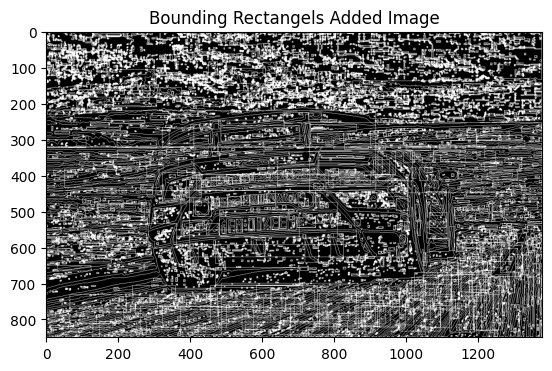

In [8]:
# Create a Contours dictionary
contours_dict = []

# Add values to the contours_dictionary
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result,
                 pt1 = (x, y),     # Start of x-axis and y-axis
                 pt2 = (x+w, y+h), # End point
                 color = (255, 255, 255),
                 thickness = 1)
    
    # Insert to dictionary
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })
    
plt.imshow(temp_result, 'gray')
plt.title('Bounding Rectangels Added Image')
plt.show()

# 6. Select Candidates by Char Size

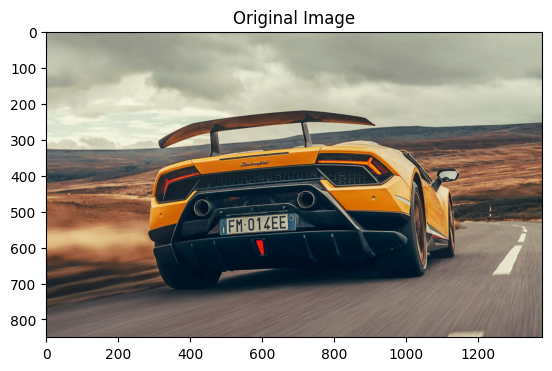

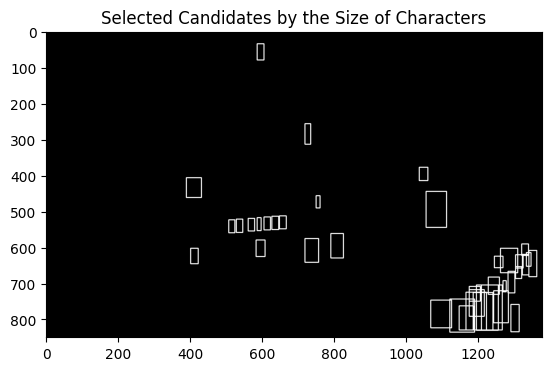

In [23]:
# Set parameters
MIN_AREA = 100
MIN_WIDTH, MIN_HEIGHT = 2, 30
MIN_RATIO, MAX_RATIO = 0.25, 0.8

# Create an empty possible contours dictionary
possible_contours = []


# Add values to the dictionary
cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# Get a result
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result,
                 pt1 = (d['x'], d['y']),
                 pt2 = (d['x'] + d['w'], d['y'] + d['h']),
                 color = (255, 255, 255),
                 thickness = 2)
    
# Visualization
plt.imshow(image_rgb)
plt.title('Original Image')
plt.show()

plt.imshow(temp_result, 'gray')
plt.title('Selected Candidates by the Size of Characters')
plt.show()

# 7. Select Candidates by Arrangement of Contours

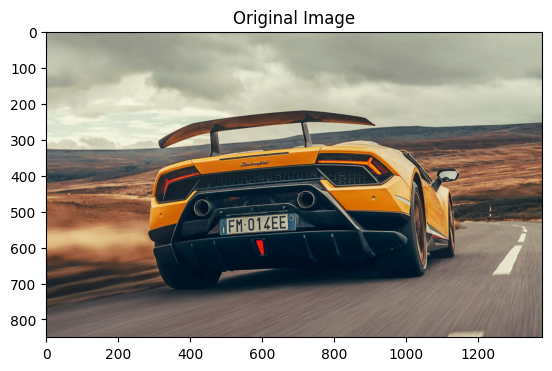

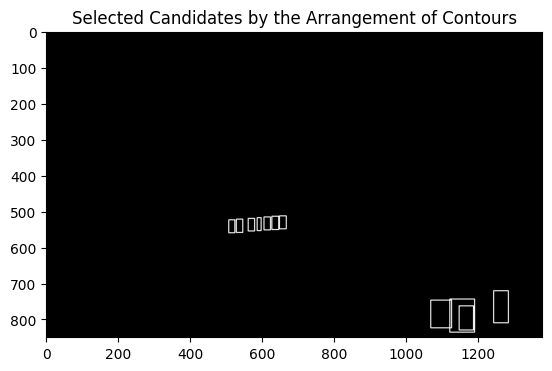

In [24]:
# Set parameters
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 4


# Difine a method of Matched Candidates
def find_chars(contour_list) : 
    
    matched_result_idx = []
    for d1 in contour_list : 
        matched_contour_idx = []
        for d2 in contour_list : 
            if d1['idx'] == d2['idx'] : 
                continue
            
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_lenghtl = np.sqrt(d1['w'] **2 + d2['h'] **2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            if dx == 0 :
                angle_diff = 90
            else : 
                angle_diff = np.degrees(np.arctan(dy / dx))
                
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_lenghtl * MAX_DIAG_MULTIPLYER and angle_diff < MAX_ANGLE_DIFF \
            and area_diff < MAX_AREA_DIFF and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF : 
                matched_contour_idx.append(d2['idx'])
                
        
        matched_contour_idx.append(d1['idx'])
        
        
        if len(matched_contour_idx) < MIN_N_MATCHED : 
            continue
            
        matched_result_idx.append(matched_contour_idx)
        
        
        # Append the contour
        unmatched_contour_idx = []
        
        for d4 in contour_list : 
            if d4['idx'] not in matched_contour_idx :
                unmatched_contour_idx.append(d4['idx'])
                
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # Recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list :
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx
    
    
# Get 'result idx'
result_idx = find_chars(possible_contours)

# Get a result
matched_result = []
for idx_list in result_idx :
    matched_result.append(np.take(possible_contours, idx_list))
    
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result : 
    for d in  r :
        x1_temp = d['x']
        y1_temp = d['y']
        w1_temp = d['w']
        h1_temp = d['h']
        cv2.rectangle(temp_result, (x1_temp,y1_temp), (x1_temp+w1_temp, y1_temp+h1_temp), (255,255,255), thickness=2)

        
# Visualization
plt.imshow(image_rgb)
plt.title('Original Image')
plt.show()

plt.imshow(temp_result, 'gray')
plt.title('Selected Candidates by the Arrangement of Contours')
plt.show()  

# 8. Rotate Horizontally the Part of Number Plates 

[array([[255, 255, 255, ...,   8,   0,   0],
       [255, 255, 255, ...,   0,   0,  16],
       [255, 255, 255, ...,   0,  24, 126],
       ...,
       [230, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]
[array([[255, 255, 255, ...,   8,   0,   0],
       [255, 255, 255, ...,   0,   0,  16],
       [255, 255, 255, ...,   0,  24, 126],
       ...,
       [230, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8), array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 230, 204, 209],
       ...,
       [222, 236, 255, ..., 174, 164, 156],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)]


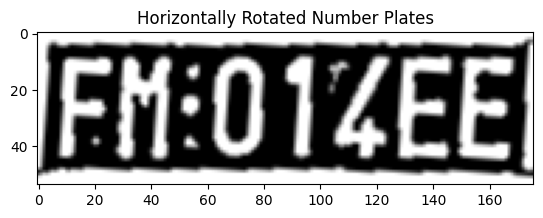

In [11]:
# Set parameters
PLATE_WIDTH_PADDING = 1.1
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10 

# Create empty lists
plate_img = []
plate_infos = []


# Find matched characters
for i, matched_chars in enumerate(matched_result) : 
    sorted_chars =  sorted(matched_chars, key=lambda x : x['cx'])
    
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
     
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0 
    for d in sorted_chars : 
        sum_height += d['h']
        
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center = (plate_cx, plate_cy), angle=angle, scale=1.0)

    image_rotated = cv2.warpAffine(image_thresh, M=rotation_matrix, dsize=(width, height))

    image_cropped = cv2.getRectSubPix(
        image_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center = (int(plate_cx), int(plate_cy))
    )
    plate_img.append(image_cropped)
    print(plate_img)

    plate_infos.append({
        'x' : int(plate_cx - plate_width / 2),
        'y' : int(plate_cy - plate_height / 2),
        'w' : int(plate_width),
        'h' : int(plate_height)
    })

    
# Visualization
plt.imshow(image_cropped, 'gray')
plt.title('Horizontally Rotated Number Plates')
plt.show()

# 9. Additional Thresholding to Find Number Plates

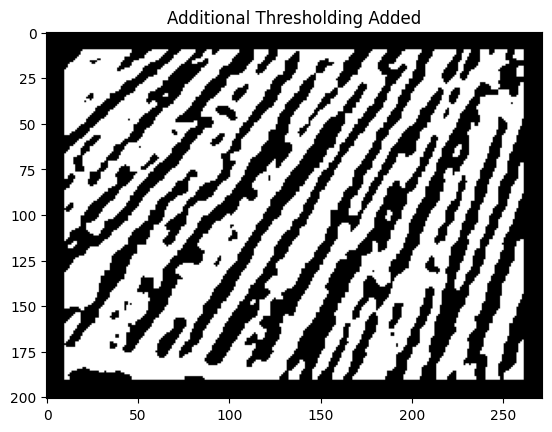

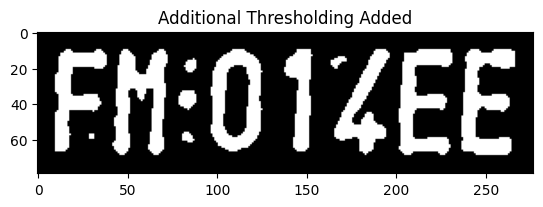

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [25]:
# Set parameters
longest_idx, longest_text = -1, 0 

# Create an empty list to get plat numbers
plate_chars = []

# Get plate numbers
for i, plate_imgs in enumerate(plate_img) :
    
    plate_imgs = cv2.resize(plate_imgs, dsize=(0,0), fx=1.6, fy=1.6)
    _, plate_imgs = cv2.threshold(plate_imgs, thresh=0.0, maxval = 255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    contours, hierarchy = cv2.findContours(plate_imgs, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_imgs.shape[1], plate_imgs.shape[0]
    plate_max_x, plate_max_y = 0, 0
    
    
    for contour in contours : 
        contour_x, contour_y, contour_w, contour_h = cv2.boundingRect(contour)
        
        area_temp = contour_w * contour_h
        ratio_temp  = contour_w / contour_h
                
        if area_temp > MIN_AREA and contour_w > MIN_WIDTH and contour_h > MIN_HEIGHT and MIN_RATIO < ratio_temp < MAX_RATIO : 
            
            if contour_x < plate_min_x :
                plate_min_x = contour_x 
            if contour_y < plate_min_y  :
                plate_min_y = contour_y
            if contour_x + contour_w > plate_max_x :
                plate_max_x = contour_x + contour_w
            if contour_y + contour_h > plate_max_y :
                plate_max_y = contour_y + contour_h
                
    img_result = plate_imgs[plate_min_y : plate_max_y, plate_min_x : plate_max_x]
    
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3,3), sigmaX=0)
    _,img_result = cv2.threshold(img_result, thresh=0.0, maxval = 255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, 
                                   borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    # Visualization
    plt.imshow(img_result, 'gray')
    plt.title('Additional Thresholding Added')
    plt.show()


text = pytesseract.image_to_string(img_result)
print(text)

# 10. Final Step to Detect the Plate Number

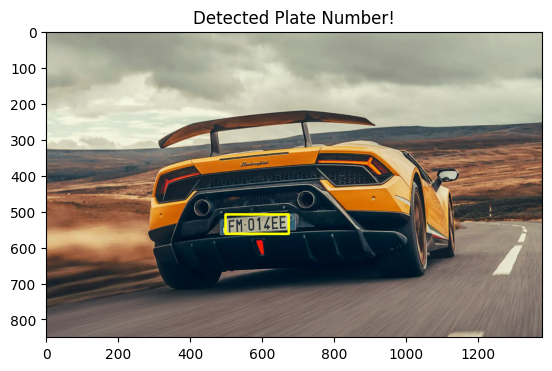

In [26]:
info = plate_infos[longest_idx]
img_out = image_rgb.copy()

# Add a rectangle
cv2.rectangle(img_out, 
              (info['x'], info['y']), 
              (info['x'] + info['w'], info['y'] + info['h']), 
              (255,255,0), 
              thickness=5)

# Visualization
plt.imshow(img_out)
plt.title('Detected Plate Number!')
plt.show()